In [ ]:
import numpy as np
import collections
import pandas as pd
import multiprocessing
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from random import sample

import gensim.models.doc2vec
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"
import gensim
from gensim.models.doc2vec import Doc2Vec

In [ ]:
def remove_source(text):
  if '-' in text[:35]:
    text = '-'.join(text.lower().split('-')[1:])
  return text

In [ ]:
true_news = pd.read_csv("True.csv")
true_news["processed_text"] = true_news.text.apply(remove_source)
true_news['fake'] = 0

In [ ]:
fake_news = pd.read_csv("Fake.csv")
fake_news['processed_text'] = fake_news.text.apply(remove_source)
fake_news['fake'] = 1

In [ ]:
data = pd.concat([true_news, fake_news]).reset_index(drop=True)


data['tokens'] = data.processed_text.apply(lambda text: gensim.utils.to_unicode(text).split())

In [ ]:
data

,title,text,subject,date,processed_text,fake,tokens
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",the head of a conservative republican faction...,0,"[the, head, of, a, conservative, republican, f..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",transgender people will be allowed for the fi...,0,"[transgender, people, will, be, allowed, for, ..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",the special counsel investigation of links be...,0,"[the, special, counsel, investigation, of, lin..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",trump campaign adviser george papadopoulos to...,0,"[trump, campaign, adviser, george, papadopoulo..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",president donald trump called on the u.s. pos...,0,"[president, donald, trump, called, on, the, u...."
...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",21st Century Wire says As 21WIRE reported earl...,1,"[21st, century, wire, says, as, 21wire, report..."
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",21st Century Wire says It s a familiar theme. ...,1,"[21st, century, wire, says, it, s, a, familiar..."
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",Patrick Henningsen 21st Century WireRemember ...,1,"[patrick, henningsen, 21st, century, wireremem..."
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",21st Century Wire says Al Jazeera America will...,1,"[21st, century, wire, says, al, jazeera, ameri..."


In [ ]:

content = data[['tokens', 'fake']].reset_index().values.tolist()

Document = collections.namedtuple('Document', 'words tags fake')


content = [Document(words=c[1], tags=[c[0]], fake=c[2]) for c in content]

In [ ]:
len(content)

44898

In [ ]:
doc_train, doc_test = train_test_split(content, random_state=42)

In [ ]:
from collections import Counter
Counter([doc.fake for doc in doc_train])

Counter({0: 16021, 1: 17652})

In [ ]:
common_kwargs = dict(
    vector_size=100,
    epochs=20,
    min_count=2,
    sample=0,
    workers=multiprocessing.cpu_count(),
    negative=5,
    hs=0,
)

model = Doc2Vec(dm=0, **common_kwargs)

model.build_vocab(content)

In [ ]:
print(model)

Doc2Vec(dbow,d100,n5,mc2,t2)


In [ ]:
model.train(content, total_examples=len(content), epochs=model.epochs)

In [ ]:
def logistic_predictor_from_data(train_targets, train_regressors):
    """Fit a statsmodel logistic predictor on supplied data"""
    logit = sm.Logit(train_targets, train_regressors)
    predictor = logit.fit(disp=0)
    return predictor


def error_rate_for_model(test_model, train_set, test_set):
    """Report error rate on test_doc , using supplied model and train_docs"""

    train_targets = [doc.fake for doc in train_set]
    train_regressors = [test_model.docvecs[doc.tags[0]] for doc in train_set]
    train_regressors = sm.add_constant(train_regressors)
    predictor = logistic_predictor_from_data(train_targets, train_regressors)

    test_regressors = [test_model.docvecs[doc.tags[0]] for doc in test_set]
    test_regressors = sm.add_constant(test_regressors)

    # Predict & evaluate
    test_predictions = predictor.predict(test_regressors)
    corrects = sum(np.rint(test_predictions) == [doc.fake for doc in test_set])
    errors = len(test_predictions) - corrects
    error_rate = float(errors) / len(test_predictions)
    return (error_rate, errors, len(test_predictions), predictor)


In [ ]:
err_rate, err_count, test_count, predictor = error_rate_for_model(model, doc_train, doc_test)
print("\n%f %s\n" % (err_rate, model))


0.046771 Doc2Vec(dbow,d100,n5,mc2,t2)



In [ ]:
err_count

525

In [ ]:
test_count

11225

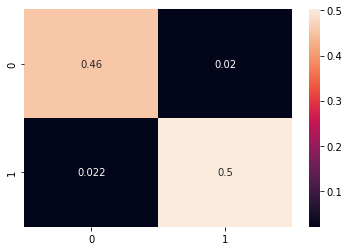

In [ ]:
import seaborn as sns

sns.heatmap(pd.DataFrame(predictor.pred_table())/len(doc_train), annot=True)